#### Demo Notebook

The purpose of this notebook is to demonstrate
- How to find caption text and coordinates from Document Intelligence API JSON and get their bounding box.
- How to find emdded images on a page using Open CV and get their bounding box using Open CV.
- How to get a single bounding box surrounding both the image and caption.
- How to save an part of a PDF page converted to an image, out to a separate file as an image.

#### Install libs as needed

In [ ]:
# uncomment and install if needed
#%pip install opencv-python
# %pip install python-dotenv
# %pip install azure-ai-formrecognizer

#### Get environment variables

In [13]:
import os
import openai
from typing import List
from dotenv import load_dotenv
# get env variables from .env file
load_dotenv()
#
# now we will set local vars from the env variables
#
# *****************************************
# Configure OpenAI API
# *****************************************
openai.api_type = "azure"
openai.api_version = os.getenv("AZURE_OPENAI_API_VERSION")
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_key = os.getenv("AZURE_OPENAI_KEY")
llm_model = os.getenv("AZURE_OPENAI_MODEL")
#
# *****************************************
# Configure OpenAI Orchestrator
# *****************************************
llm_max_tokens = os.getenv("AZURE_OPENAI_MAX_TOKENS")
embedding_model = os.getenv("AZURE_OPENAI_EMBEDDING_MODEL")
#
# *****************************************
# Configure Document Intelligence API
# *****************************************
sas_key = os.getenv("AZURE_BLOB_ACCOUNT_SAS_KEY")
form_recognizer_key = os.getenv("AZURE_FORM_RECOGNIZER_KEY")
form_recognizer_endpoint = os.getenv("AZURE_FORM_RECOGNIZER_ENDPOINT")
storage_account_url = os.getenv("AZURE_BLOB_ACCOUNT_URL")
container_name=os.getenv("AZURE_BLOB_CONTAINER_NAME")
test_document_name=os.getenv("TEST_DOCUMENT_NAME")
skip=0
# Just for debugging, print out values
# Dont leave values in output when checking in
if skip==1:
    print(sas_key)
    print(openai.api_type)
    print(openai.api_version)
    print(openai.api_base)
    print(openai.api_key)
    print(llm_model)
    print(llm_max_tokens)
    print(embedding_model)
    print(form_recognizer_key)
    print(form_recognizer_endpoint)
    print(storage_account_url)
    print(container_name)
    print(test_document_name)

#### Create some functions I will need later

In [14]:
import cv2 
import numpy as np
#
def get_content(pdf_document, pages_to_ocr):
    import os
    from azure.ai.formrecognizer import DocumentAnalysisClient
    from azure.core.credentials import AzureKeyCredential

    # The endpoint and key values are in the .env file
    # form_recognizer_key taken from env variable in prior cell
    # form_recognizer_endpoint from env variable  in prior cell
    #
    document_analysis_client = DocumentAnalysisClient(endpoint=form_recognizer_endpoint, credential=AzureKeyCredential(form_recognizer_key))
    model="prebuilt-layout"
    #model="prebuilt-document"
    #
    # call the Document Intelligence API
    with open(pdf_document, "rb") as f:
        poller = document_analysis_client.begin_analyze_document(model, document=f, locale="en-US", pages=pages_to_ocr)
    #
    # return  the result
    result = poller.result()
    return result


# tuplify
def tup(point):
    return (point[0], point[1])

# returns true if the two boxes overlap
def overlap(source, target):
    # unpack points
    tl1, br1 = source
    tl2, br2 = target

    # checks
    if (tl1[0] >= br2[0] or tl2[0] >= br1[0]):
        return False
    if (tl1[1] >= br2[1] or tl2[1] >= br1[1]):
        return False
    return True

# returns all overlapping boxes
def getAllOverlaps(boxes, bounds, index):
    overlaps = []
    for a in range(len(boxes)):
        if a != index:
            if overlap(bounds, boxes[a]):
                overlaps.append(a)
    return overlaps

def medianCanny(img, thresh1, thresh2):
    median = np.median(img)
    img = cv2.Canny(img, int(thresh1 * median), int(thresh2 * median))
    return img

def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

def get_rectangles(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    rectangles_out=[]
    ## this will get all the shapes on the pages
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # skip lines we're looking for rectangles
    # cnts will hold all the shapes
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    #
    # Now lets loop through the shapes and find the rectangles
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.015 * peri, True)
        # this will filter everything except the rectangles
        if len(approx) == 4:
            x,y,w,h = cv2.boundingRect(approx)
            # We only want the larger ones
            if h > 200:
                rectangles_out.append([x,y,w,h])
    return rectangles_out

def get_rectangles_around_image_plus_text(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    rectangles_out=[]
    ## this will get all the shapes on the pages
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # skip lines we're looking for rectangles
    # cnts will hold all the shapes
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    #
    # Now lets loop through the shapes and find the rectangles
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.015 * peri, True)
        # this will filter everything except the rectangles
        if len(approx) == 4:
            x,y,w,h = cv2.boundingRect(approx)
            # We only want the larger ones
            if h > 200:
                rectangles_out.append([x,y,w,h])
    return rectangles_out
    
    

#### OCR 1 page as a demo

Page 22 from sample document FMDS0200.pdf.

In [26]:
# first I will do OCR on a local copy of the pdf (only page 22, printed pag 23 )
#
# set the path for the test pdf
pdf_document = r"./FMDS0200.pdf"
# call my function which in-turn calls the Azure Form Recognizer API
# and does OCR for just the 1 page
result = get_content(pdf_document,"23")
pages=result.pages
for line_idx, line in enumerate(pages[0].lines):
    print(line_idx, line.content)
#
# Notice 1) I get get back the text from the page   
#    and 2) I get back the text from inside the the image as well
#    and 3) I get back the bounding box for the text
#

0 Installation Guidelines for Automatic Sprinklers
1 2-0
2 FM Global Property Loss Prevention Data Sheets
3 Page 23
4 2.2.5.4 Gaseous Medium Supplies for Refrigerated-Area Sprinkler Systems
5 2.2.5.4.1 Use an inert gaseous medium, such as nitrogen, or a gaseous medium that is FM Approved
6 specifically for the occupancy hazard application, for maintaining internal pressure within a refrigerated-area
7 sprinkler system. Ensure the inert gaseous medium used in the refrigerated-area sprinkler system is
8 compatible with all sprinkler system components.
9 2.2.5.4.2 The use of air as a gaseous medium for maintaining internal pressure within a refrigerated-area
10 sprinkler system is an acceptable alternative to an inert gaseous medium when an adequately sized FM
11 Approved dry air unit system for a refrigerated-area sprinkler system is provided. Arrange the air intake for
12 compressed air as follows:
13 A. The air is taken from the protected area, or
14 B. The air can be taken from room t

#### Create a function to get the bounding boxes for the titles of any diagrams on the page.

In [16]:
import cv2 
#
# *********************************************
# Note: I uses title and caption interchangably.
# In my sample documents, the caption (title)
# is the decription of the figure or table 
# that is directly below the figure or table
# **********************************************
#
#
def get_bounding_boxes_around_text(page):
    # From the Doc. Intel. API's returned JSON, I want to get
    # the bounding box for the text which is directly
    # below the figure. It starts with "Fig.".I will use 
    # the polygon properties to get the coordiates of the text
    # There may be more than one on the page so I'll put them in a list
    #
    b_boxes=[]
    titles_to_keep=[]
    # we are looking for lines that looks like "Fig. 2.2.5.3. blah blah blah"
    for line_idx, line in enumerate(page.lines):
        if line.content.startswith("Fig."):
            # get the bounding box
            b_box=line.polygon
            #
            # get the substring of everything between 
            # the first and second space in the line
            mystart=line.content.find(" ")
            myend=line.content.find(" ", mystart+1)
            #
            # we now have the caption
            title_to_keep=line.content[mystart+1:myend]
            #
            # now drop the last character which is a period
            title_to_keep=title_to_keep[:-1]
            # print("title_to_keep={}".format(title_to_keep))
            #
            # The bounding box will be made up of 4 points
            # print(b_box)
            #
            # Lets add it to our list of bounding boxes
            b_boxes.append(b_box)
            #
            # and the title to our list of titles
            titles_to_keep.append(title_to_keep)
            #
    # We will return both list to the client
    return b_boxes, titles_to_keep

def get_page_dims(page):
    page_width_in_inches=page.width
    page_height_in_inches=page.height
    return page_width_in_inches, page_height_in_inches
    
print("Functions created")    



Functions created


#### Execute the function

It will return 2 lists. 
One with bounding boxes for the titles found on the page.  
Note that the coordinates will be in inches not pixels.  
(PDFs return coordinates in inches, Images coordinates return in pixels).  
The other will be a list of the titles text.

Also getting the page width and height (also in inches).

In [27]:
# Main code
#
## get the bounding boxes for the text
page=result.pages[0]
b_boxes, titles_to_keep = get_bounding_boxes_around_text(page)
for b_box in b_boxes:
    for title in titles_to_keep:
        print("title: {} , in inches:{}".format(title , b_box))
#
# For the conversion I will also need the page dimensions and dpi unit and the number of units per inch
page_width_in_inches,page_height_in_inches= get_page_dims(page)
print("page_width={}\tpage_height={}".format(page_width_in_inches, page_height_in_inches))
#
# Each point represents its x, y coordinate in the page unit specified by the unit property. In general, unit of measure for images is pixels while PDFs use inches.
# see https://github.com/MicrosoftDocs/azure-docs/blob/main/articles/ai-services/document-intelligence/concept-analyze-document-response.md for a sample
#

title: 2.2.5.4.3 , in inches:[Point(x=1.404, y=9.2526), Point(x=7.0821, y=9.2526), Point(x=7.0821, y=9.3911), Point(x=1.404, y=9.3911)]
page_width=8.4861	page_height=11.0


#### To demostrate that I have valid image title coordinates, I will draw agreen box around it.

I will use Open CV to draw the rectangle.  
It requires coordinates in pixels so I must do a conversion first.

Below I create a function to do the conversion.

In [18]:
# Note that this function expects an image to be passed in, not a pdf
import numpy as np

def convert_inches_to_pixels(image, b_boxes):
    import cv2 
    import numpy as np
    # before I can draw a green box around the text
    # I must convert the coordinates from the ocr
    # which in inched on the pdf to pixels on the image    
    #
    # get the image size (h,w) in pixels
    image_height_in_pixels, image_width_in_pixels = image.shape[:2]
    # image_height_in_pixels, image_width_in_pixels = image.size
    print("image_width={}\timage_height={}".format(image_width_in_pixels, image_height_in_pixels))
    #
    image_coord_in_pixels=[]
    for point1,point2,point3,point4 in b_boxes:
        #convert the points to x, y
        x0,y0=point1.x,point1.y
        x1,y1=point2.x,point2.y
        x2,y2=point3.x,point3.y
        x3,y3=point4.x,point4.y
        # convert the inches to pixels
        # the formula is # (coordinate in inches/side in inches)*side in pixel = new coordinate in pixel 
        x0=int((x0/page_width_in_inches)*image_width_in_pixels)
        x1=int((x1/page_width_in_inches)*image_width_in_pixels)
        x2=int((x2/page_width_in_inches)*image_width_in_pixels)
        x3=int((x3/page_width_in_inches)*image_width_in_pixels)
        y0=int((y0/page_height_in_inches)*image_height_in_pixels)
        y1=int((y1/page_height_in_inches)*image_height_in_pixels)
        y2=int((y2/page_height_in_inches)*image_height_in_pixels)
        y3=int((y3/page_height_in_inches)*image_height_in_pixels)
        image_coord_in_pixels.append([(x0,y0),(x1,y1),(x2,y2),(x3,y3)])
    return image_coord_in_pixels


def convert_pdf_page_to_image(pdf_document_path, page_no):
    import pypdfium2 as pdfium
    filepath = pdf_document_path
    pdf = pdfium.PdfDocument(filepath)

    # render a single page (in this case: the first one)
    page = pdf[page_no]
    pil_image = page.render(scale=4).to_pil()
    # open cv will need a numpy array
    image=np.array(pil_image)
    return image
    

#### Execute the function to draw the bounding box around the caption

image_width=2447	image_height=3168


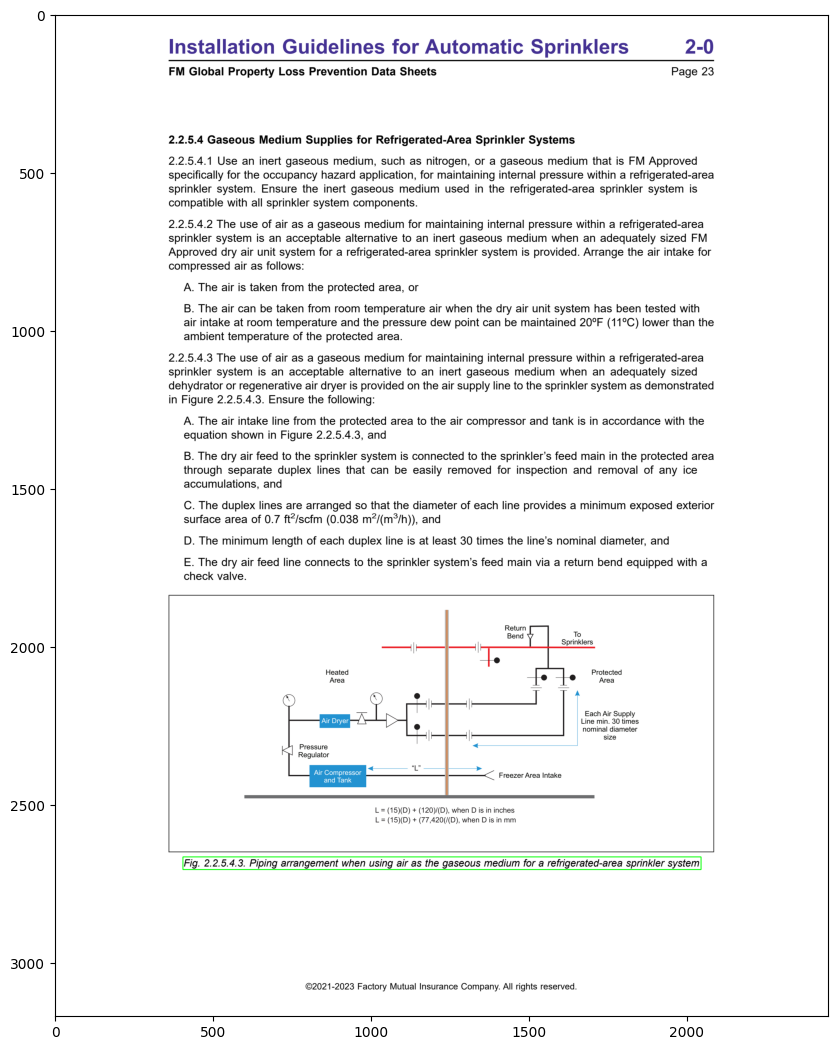

In [28]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import cv2 
#
# convert the PDF page to an image
filepath = "./FMDS0200.pdf"
np_image = convert_pdf_page_to_image(filepath,22)
#
# I will use the OCR results from my earlier 
# Document Intelligence API call forr page 22
page=result.pages[0]
#
# get the bounding boxes for the titles on the pages (may be more than one)
# by calling the function I created earlier
b_boxes, titles_to_keep=get_bounding_boxes_around_text(page)
#
# Now convert the inches to pixels 
# by calling the function created in the prior cell
image_coord_in_pixels = convert_inches_to_pixels(np_image, b_boxes)
#
# loop through and draw the rectangles around the titles
for b_box in image_coord_in_pixels:
    # draw the rectangle
    cv2.rectangle(np_image, b_box[0], b_box[2], (0, 255, 0), 2)
#    
# show the image
plt.figure(figsize=(13,13))
plt.imshow(np_image)
plt.show()

# The text below the image is now hihglighted in green

#### The coordinates of the embedded images are not in the JSON. It only has coordinates for the text blocks.

To determine the coordinates of the embedded image I will use Open CV.  
I create a function earlier (get_rectangles) that will find rectangleular shapes on a image.  
It will return the top left coordinates, the width and the height of the bounding box for those shapes on the page.  

I can then draw a green box around it too.

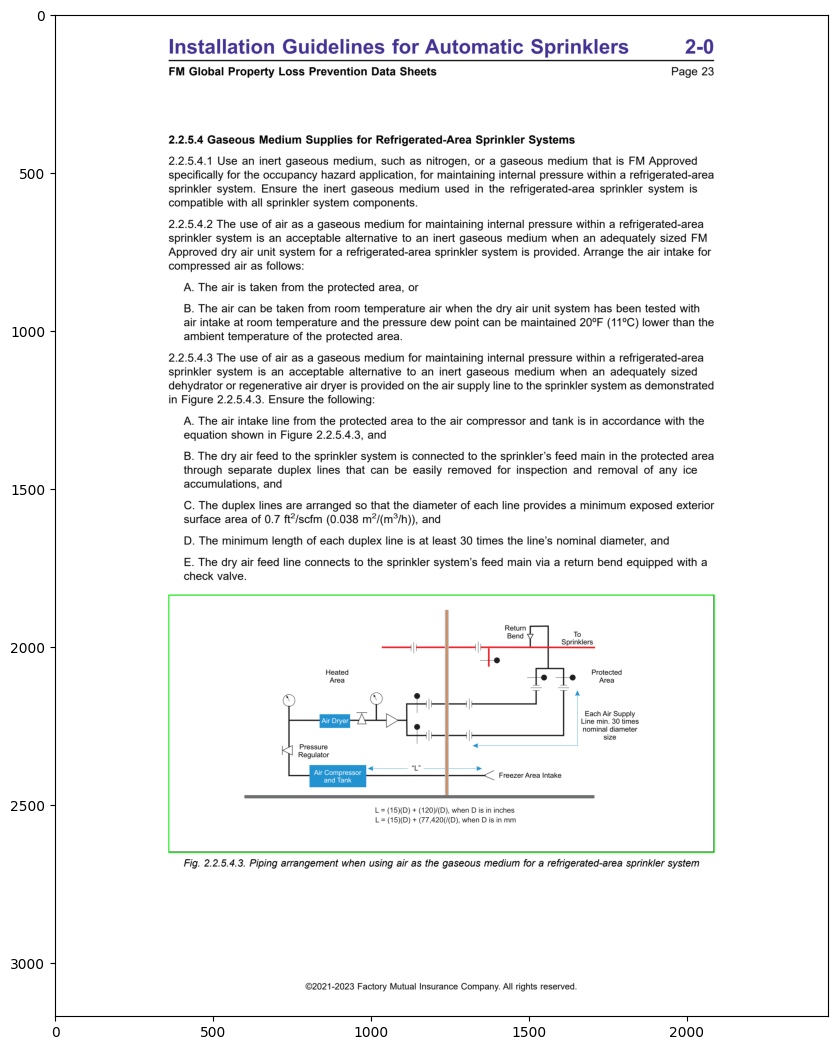

In [29]:
# main code
import matplotlib.pyplot as plt
from matplotlib import rcParams
import cv2 
#
# convert the PDF page to an image
filepath = "./FMDS0200.pdf"
image = convert_pdf_page_to_image(filepath,22)
#
rectangles_out=get_rectangles(image)
# loop through and draw the rectangles around the titles
for x,y,w,h in rectangles_out:
    #
    # draw the rectangle
    cv2.rectangle(image, (x,y), (x+w,y+h), (0, 255, 0), 2)
#
# show the image
plt.figure(figsize=(13,13))
plt.imshow(image)
plt.show()

#### Create a function to determine a bounding box around both the image and caption and draw a single box 

In [30]:
#
def draw_rect_around_both(image,page):
    import cv2 
    import numpy as np
    #
    rectangles_out=get_rectangles(image)
    b_boxes, titles_to_keep=get_bounding_boxes_around_text(page)    
    image_coord_in_pixels = convert_inches_to_pixels(image, b_boxes)
    #
    for x,y,w,h in rectangles_out:
        for b_box in image_coord_in_pixels:
            # draw a green rectanle onto the image
            # the bottom tight corner of the text is: b_box[2]
            x_bottom_right_title,y_bottom_right_title = b_box[2]
            # the top_left_corner of the title is: b_box[0]
            x_top_left_title,y_top_left_title = b_box[0]
            # tope left corner of the rectangle
            x_top_left_rect,y_top_left_rect = x,y
            # bottom right corner of the rectangle
            x_bottom_right_rect,y_bottom_right_rect = x+w,y+h
            # use the leftmost x cordinate of the two and
            # use the rightmost x cordinate of the two
            # and use the top y cordinage of the image
            # and use the bottom coordinate of the text
            x_top_left = min(x_top_left_title,x_top_left_rect)
            y_top_left = min(y_top_left_title,y_top_left_rect)
            x_bottom_right = max(x_bottom_right_title,x_bottom_right_rect)
            y_bottom_right = max(y_bottom_right_title,y_bottom_right_rect)
            # draw the rectangle
            cv2.rectangle(image,(x_top_left,y_top_left),(x_bottom_right,y_bottom_right),(36,255,12),2)
            # cv2.rectangle(image,(x,y),(x+w,y+h),(36,255,12),2)
    return image

#### Execute the function to draw the bounding box around both the image and caption

image_width=2447	image_height=3168


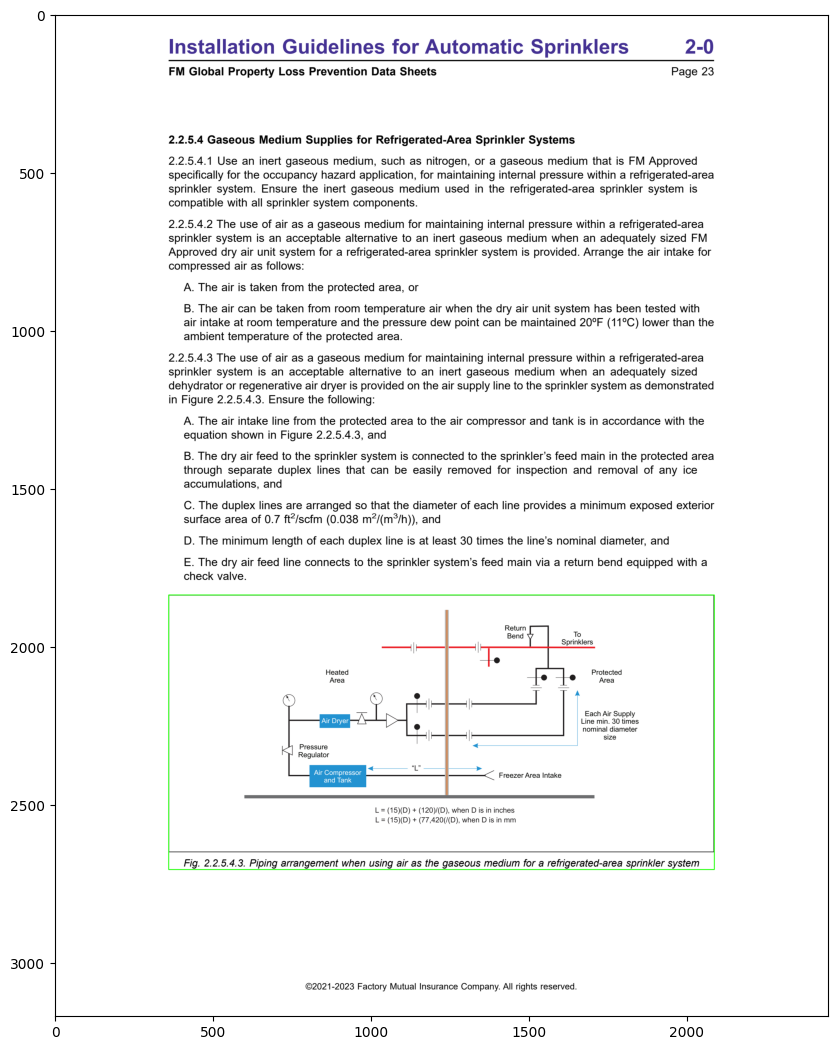

In [31]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import rcParams

# convert the PDF page to an image
filepath = "./FMDS0200.pdf"
image = convert_pdf_page_to_image(filepath,22)
#
# I still need the JSON to locate the text
page=result.pages[0]
#
# draw the green bounding box
image = draw_rect_around_both(image, page)
# 
# lets show it
rcParams['figure.figsize'] = 13 ,13
plt.imshow(image)
plt.show() 

#### Instead of drawing the green box, I will extract the image to a file.

I will create a function to save the diagram and title as an as one single image on disk.

In [32]:
# This does almost the same as the previous code cell 
# except we want to cut out the images and save them
# to disk
# Also instead of using the bottom x value of the image 
# We want to use th elower x value of the text
import cv2 
import numpy as np
#
def cutout_image_around_both(image, page):
    cutouts=[]
    rectangles_out=get_rectangles(image)
    b_boxes, titles_to_keep=get_bounding_boxes_around_text(page)    
    image_coord_in_pixels = convert_inches_to_pixels(image, b_boxes)
    #
    for x,y,w,h in rectangles_out:
        for b_box in image_coord_in_pixels:
            # cutout a rectanle onto the image
            # the bottom tight corner of the text is: b_box[2]
            x_bottom_right_title,y_bottom_right_title = b_box[2]
            # the top_left_corner of the title is: b_box[0]
            x_top_left_title,y_top_left_title = b_box[0]
            # tope left corner of the rectangle
            x_top_left_rect,y_top_left_rect = x,y
            # bottom right corner of the rectangle
            x_bottom_right_rect,y_bottom_right_rect = x+w,y+h
            # use the leftmost x cordinate of the two and
            # use the rightmost x cordinate of the two
            # and use the top y cordinage of the image
            # and use the bottom coordinate of the text
            x_top_left = min(x_top_left_title,x_top_left_rect)
            y_top_left = min(y_top_left_title,y_top_left_rect)
            x_bottom_right = max(x_bottom_right_title,x_bottom_right_rect)
            y_bottom_right = max(y_bottom_right_title,y_bottom_right_rect)
            # cutout the rectangle
            cutouts.append(image[y_top_left:y_bottom_right, x_top_left:x_bottom_right])
    # return the cutout images
    return cutouts, titles_to_keep

    
    

#### Execute the function to save the image

image_width=2447	image_height=3168


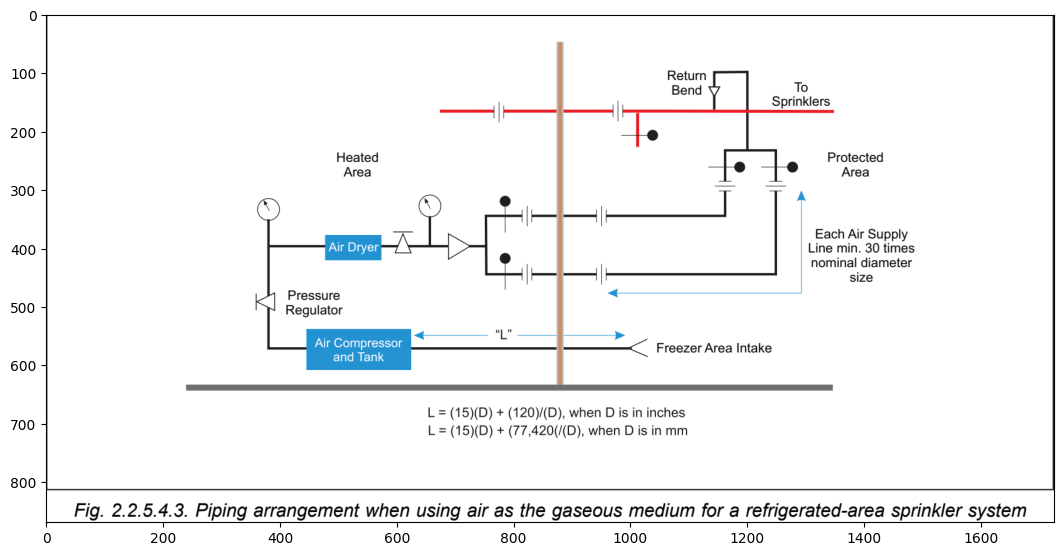

The image file has been saved to Figure 2.2.5.4.3.png


In [33]:
import cv2 
import matplotlib.pyplot as plt
from matplotlib import rcParams
#
# convert the PDF page to an image
filepath = "./FMDS0200.pdf"
image = convert_pdf_page_to_image(filepath,22)
#
# I still need the JSON to locate the text
page=result.pages[0]
#
# call the function to do the cutouts
cutouts_out, titles_to_keep = cutout_image_around_both(image,page)
#
# Now lets loop through the images and save them to disk
for image in cutouts_out:
    for title in titles_to_keep:
        # save it to disk
        final_title="Figure " + title + ".png"
        # write it to disk
        cv2.imwrite(str(final_title), image)
# loop through and show the images
for img in cutouts_out:
    plt.figure(figsize=(13,13))
    plt.imshow(img)
    plt.show()
print("The image file has been saved to {}".format(final_title))

### Recap 

In this nobook we looked 
- How to find caption text and coordinates from Document Intelligence API JSON and get their bounding box.
- How to find emdded images on a page using Open CV and get their bounding box using Open CV.
- How to get a single bounding box surrounding both the image and caption.
- How to save an part of a PDF page converted to an image, out to a separate file as an image.